In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
m = torch.nn.Linear(20, 30)
input = torch.autograd.Variable(torch.randn(128, 20))
output = m(input)
print(output.size())

torch.Size([128, 30])


In [3]:
# parameters
mu, sigma = -2., 1.5
data_range = 5

input_size = 1
z_size = 1
hidden_size = 32

learning_rate = 0.03
n_epochs = 500
M = 1000 # batch size

In [4]:
class DataDistribution(object):
    def __init__(self, data_range, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.data_range = data_range

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
#         min_s = np.min(samples)
#         max_s = np.max(samples)
#         samples = (samples - min_s) / (max_s - min_s)
        min_s = -self.data_range
        max_s = self.data_range
        samples = (samples - min_s) / (max_s - min_s)
        samples = samples * 2 - 1
        return samples
    
    def sample_raw(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        return samples

In [5]:
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + np.random.random(N) * 0.01
        #return np.random.uniform(-1, 1, N)

In [6]:
class Generator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        layer = torch.nn.functional.leaky_relu(self.layer1(x))
        return torch.nn.functional.tanh(self.layer2(layer))

In [7]:
class Discriminator(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        layer = torch.nn.functional.leaky_relu(self.layer1(x))
        return torch.nn.functional.sigmoid(self.layer2(layer))

In [8]:
def test_samples(D, G, d_data, g_data, sample_range, batch_size, num_points=10000, num_bins=100):
    # decision boundary
    xs = np.linspace(-1, 1, num_points)
    db = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        curr_loc = batch_size * i
        next_loc = batch_size * (i + 1)
        x_ = xs[curr_loc:next_loc]
        x_ = torch.Tensor(np.reshape(x_, [batch_size, 1]))
        x_ = torch.autograd.Variable(x_)
        
        db[curr_loc:next_loc] = D(x_).data.numpy()

    # data distribution
    bins = np.linspace(-sample_range, sample_range, num_bins)
    d = d_data.sample_raw(num_points)
    pd, _ = np.histogram(d, bins=bins, density=True)

    # generated samples
    zs = g_data.sample(num_points)
    #zs = np.linspace(-sample_range, sample_range, num_points)
    g = np.zeros((num_points, 1))
    for i in range(num_points // batch_size):
        curr_loc = batch_size * i
        next_loc = batch_size * (i + 1)
        
        z_ = zs[curr_loc:next_loc]
        z_ = torch.Tensor(np.reshape(z_, [batch_size, 1]))
        z_ = torch.autograd.Variable(z_)
        g_raw_out = G(z_).data.numpy()
        g[curr_loc:next_loc] = g_raw_out * sample_range
    pg, _ = np.histogram(g, bins=bins, density=True)

    return db, pd, pg

In [9]:
def plot_distributions(samps, sample_range):
    db, pd, pg = samps
    db_x = np.linspace(-sample_range, sample_range, len(db))
    p_x = np.linspace(-sample_range, sample_range, len(pd))
    f, ax = plt.subplots(1)
    ax.plot(db_x, db, label='decision boundary')
    ax.set_ylim(0, 1)
    ax.set_xlim(-sample_range, sample_range)
    plt.plot(p_x, pd, label='real data')
    plt.plot(p_x, pg, label='generated data')
    plt.title('1D Generative Adversarial Network')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()

In [10]:
data = DataDistribution(data_range, mu, sigma)
gen = GeneratorDistribution(data_range)

In [11]:
G = Generator(input_size=z_size, hidden_size=hidden_size, output_size=1)
D = Discriminator(input_size=input_size, hidden_size=hidden_size, output_size=1)

In [12]:
# coefficients used for computing running averages 
# of gradient and its square (default: (0.9, 0.999))
optim_betas = (0.9, 0.999)
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=optim_betas)
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=optim_betas)

# Binary cross entropy
criterion = torch.nn.BCELoss()

In [13]:
d_losses = []
g_losses = []
for e in range(n_epochs):
    # 1. Train D on real+fake
    D.zero_grad()
    
    #  1A: Train D on real
    x_ = data.sample(M)
    x_ = torch.Tensor(np.reshape(x_, [M, input_size]))
    labels_x_ = torch.ones([M, input_size])
    d_real_data = torch.autograd.Variable(x_)
    d_real_decision = D(d_real_data)
    d_real_error = criterion(d_real_decision, torch.autograd.Variable(labels_x_)) 
    d_real_error.backward() # compute/store gradients, but don't change params
    
    #  1B: Train D on fake
    z1_ = gen.sample(M)
    z1_ = torch.Tensor(np.reshape(z1_, [M, z_size]))
    labels_z1_ = torch.zeros([M, input_size])
    d_gen_input = torch.autograd.Variable(z1_)
    d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
    d_fake_decision = D(d_fake_data)
    d_fake_error = criterion(d_fake_decision, torch.autograd.Variable(labels_z1_))
    d_fake_error.backward()
    d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()
    
    
    # 2. Train G on D's response (but DO NOT train D on these labels)
    G.zero_grad()
    z2_ = gen.sample(M)
    z2_ = torch.Tensor(np.reshape(z2_, [M, z_size]))
    labels_z2_ = torch.ones([M, z_size])
    gen_input = torch.autograd.Variable(z2_)
    g_fake_data = G(gen_input)
    dg_fake_decision = D(g_fake_data)
    g_error = criterion(dg_fake_decision, torch.autograd.Variable(labels_z2_))
    g_error.backward()
    g_optimizer.step()
    
    # Save losses to view after training
    d_losses.append(d_real_error[0].data.numpy())
    g_losses.append(g_error[0].data.numpy())
        
    if e % 100 == 0:
        print('{}: D: {}/{} G: {}'.format(e, d_real_error[0].data.numpy(), 
                                          d_fake_error[0].data.numpy(), 
                                          g_error[0].data.numpy()))
    
    if e == n_epochs-1:
        samps = test_samples(D, G, data, gen, data_range, M)
        
        print('d_real_error size: {}, d_fake_error: {}, g_error: {}'.format(d_real_error.size(),
                                                                            d_fake_error.size(),
                                                                            g_error.size()))

0: D: [ 0.66468269]/[ 0.67299587] G: [ 0.80284667]
100: D: [ 0.4016721]/[ 0.27022386] G: [ 1.55773485]
200: D: [ 0.7262969]/[ 0.67800832] G: [ 0.70535219]
300: D: [ 0.66323805]/[ 0.74253327] G: [ 0.64592254]
400: D: [ 0.69746304]/[ 0.69561177] G: [ 0.68943381]
d_real_error size: torch.Size([1]), d_fake_error: torch.Size([1]), g_error: torch.Size([1])


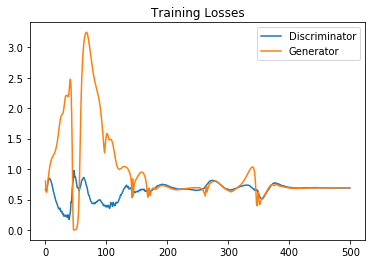

In [14]:
fig, ax = plt.subplots()
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.title("Training Losses")
plt.legend()

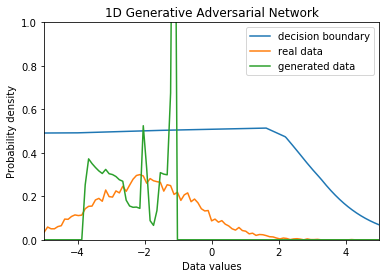

In [15]:
plot_distributions(samps, data_range)